In [31]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Add, Conv2D, BatchNormalization, ReLU, LeakyReLU, UpSampling2D, Concatenate, AveragePooling2D, Activation, ZeroPadding2D, MaxPooling2D, Dense, Flatten
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import imageio
from matplotlib.pyplot import imshow
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
import datetime
%matplotlib inline

import keras.backend as K

In [23]:
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

<h2>Generator</h2>

<h3>Content Encoder</h3>

In [8]:
def content_encoder(shape):
    X_input = Input(shape=shape)
    
    X = Conv2D(64, kernel_size=1, strides=1, padding='same')(X_input)
    X = InstanceNormalization()(X)
    X = ReLU()(X)
    
    X = Conv2D(128, kernel_size=1, strides=2, padding='same')(X)
    X = InstanceNormalization()(X)
    X = ReLU()(X)
    
    X = Conv2D(256, kernel_size=1, strides=2, padding='same')(X)
    X = InstanceNormalization()(X)
    X = ReLU()(X)
    
    X = Conv2D(512, kernel_size=1, strides=2, padding='same')(X)
    X = InstanceNormalization()(X)
    X = ReLU()(X)
    
    X_shortcut = X
    
    X = Conv2D(512, kernel_size=1, strides=1, padding='same')(X)
    X = InstanceNormalization()(X)
    X = Add()([X_shortcut, X])
    X = ReLU()(X)
    
    X_shortcut = X
    
    X = Conv2D(512, kernel_size=1, strides=1, padding='same')(X)
    X = InstanceNormalization()(X)
    X = Add()([X_shortcut, X])
    X = ReLU()(X)
    
#     model = Model(inputs=X_input, outputs=X, name='content_encoder')
#     return model

    return X

In [10]:
X = content_encoder(img_shape)
X.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(512)])

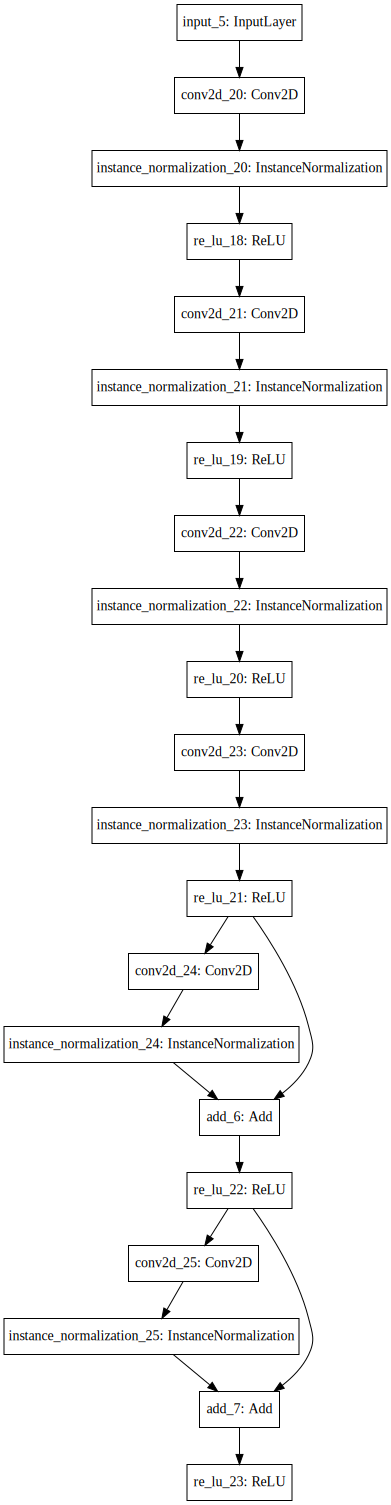

In [13]:
model = content_encoder(img_shape)
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

<h3>Class Encoder</h3>

In [19]:
def class_encoder_k(shape):
    Y_input = Input(shape=shape)
    
    Y = Conv2D(64, kernel_size=1, strides=1, padding='same')(Y_input)
    Y = ReLU()(Y)
    
    Y = Conv2D(128, kernel_size=1, strides=2, padding='same')(Y)
    Y = ReLU()(Y)
    
    Y = Conv2D(256, kernel_size=1, strides=2, padding='same')(Y)
    Y = ReLU()(Y)
    
    Y = Conv2D(512, kernel_size=1, strides=2, padding='same')(Y)
    Y = ReLU()(Y)
    
    Y = Conv2D(1024, kernel_size=1, strides=2, padding='same')(Y)
    Y = ReLU()(Y)
    
    Y = AveragePooling2D()(Y)
    
#     Y = Dense(512)(Y)
    Y = Flatten()(Y)
    
    return Y

In [20]:
k = 1

In [36]:
def class_encoder(Y):
    total = 0
    for i in range (0, k):
        val = class_encoder_k(Y.shape)
        total = np.add(total, val)
    mean = tf.math.reduce_mean(total)
    print(mean)
    return mean

In [34]:
mean = class_encoder()

Tensor("Mean_1:0", shape=(), dtype=float32)


<h3>Decoder</h3>

In [5]:
def adain_resblk(X, f, filters, stage, s):
    conv_name_base = 'adain_resblk_' + stage
    F1, F2, F3 = filters
    
    X_shortcut = X
    print(X_shortcut)
    
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = InstanceNormalization(beta_regularizer=beta_2, gamma_regularizer=gamma)(X)
    X = ReLU()(X)
    print(X)
    
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = InstanceNormalization(beta_regularizer=beta_2, gamma_regularizer=gamma)(X)
    X = ReLU()(X)
    print(X)
    
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    
    print(X, X_shortcut)
    X = Add()([X, X_shortcut])
    X = ReLU()(X)
    
    return X

In [ ]:
def conv(X, f_size):
    X = Conv2D(X, kernel_size=f_size, strides=2, padding='valid')(X)
    X = InstanceNormalization()(X)
    X = ReLU()(X)
    return X

In [6]:
def decoder(content_code, class_code):
    X = Dense(256)(class_code)
    X = Dense(256)(X)
    X = Dense(256)(X)
    X = Flatten()(X)
    
    beta = np.var(X, axis=(1,2))
    beta_2 = beta**2
    gamma = np.mean(X, axis=(1,2))
    
    Y = adain_resblk(content_code, f=3, filters=[512, 512, 512], stage=1, s=1)
    Y = adain_resblk(Y, f=3, filters=[512, 512, 512], stage=2, s=1)
    Y = conv(Y, f_size=256)
    Y = conv(Y, f_size=128)
    Y = conv(Y, f_size=64)
    Y = conv(Y, f_size=3)
    
    return Y

In [42]:
def generator(X_input, Y):
    content_code = content_encoder(X_input.shape)
    class_code = class_encoder(Y)
    X_gen = decoder(content_code, class_code)
    model = Model(inputs=[X_input, Y], outputs=X_gen)
    return model

<h2>Discriminator</h2>

In [47]:
def res_block(X, f, filters, stage, s):
    conv_name_base = 'resblk_' + str(stage)
    F1, F2, F3 = filters
    
    X_shortcut = X
    print(X_shortcut)
    
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + 'a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = LeakyReLU()(X)
    print(X)
    
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + 'b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = LeakyReLU()(X)
    print(X)
    
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + 'c', kernel_initializer=glorot_uniform(seed=0))(X)
    
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    
    print(X, X_shortcut)
    X = Add()([X, X_shortcut])
    X = LeakyReLU()(X)
    
    return X

In [45]:
def discriminator():
    X_input = Input(img_shape)

    X = Conv2D(64, kernel_size=3, strides=2, padding='same')(X_input)

    X = res_block(X, f=3, filters=[64, 64, 128], stage=1, s=1)
    X = res_block(X, f=3, filters=[128, 128, 128], stage=2, s=1)

    X = AveragePooling2D(strides=2)(X)

    X = res_block(X, f=3, filters=[128, 128, 256], stage=3, s=1)
    X = res_block(X, f=3, filters=[256, 256, 256], stage=4, s=1)

    X = AveragePooling2D(strides=2)(X)

    X = res_block(X, f=3, filters=[256, 256, 512], stage=6, s=1)
    X = res_block(X, f=3, filters=[512, 512, 512], stage=7, s=1)

    X = AveragePooling2D(strides=2)(X)

    X = res_block(X, f=3, filters=[512, 512, 1024], stage=8, s=1)
    X = res_block(X, f=3, filters=[1024, 1024, 1024], stage=9, s=1)

    X = AveragePooling2D(strides=2)(X)

    X = res_block(X, f=3, filters=[1024, 1024, 1024], stage=11, s=1)
    X = res_block(X, f=3, filters=[1024, 1024, 1024], stage=12, s=1)

    number_source_class = 10
    X = Conv2D(number_source_class, kernel_size=1, strides=1, padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X)
    return model

In [46]:
discriminator()

Tensor("conv2d_37/BiasAdd:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("leaky_re_lu_91/LeakyRelu:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("leaky_re_lu_92/LeakyRelu:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("resblk_12c_6/BiasAdd:0", shape=(?, 64, 64, 128), dtype=float32) Tensor("resblk_11_6/BiasAdd:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("leaky_re_lu_93/LeakyRelu:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("leaky_re_lu_94/LeakyRelu:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("leaky_re_lu_95/LeakyRelu:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("resblk_22c_6/BiasAdd:0", shape=(?, 64, 64, 128), dtype=float32) Tensor("resblk_21_6/BiasAdd:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("average_pooling2d_19/AvgPool:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("leaky_re_lu_97/LeakyRelu:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("leaky_re_lu_98/LeakyRelu:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("resblk_32c_6/BiasAdd:0", sha

<h2>Load data</h2>

In [2]:
import scipy.io
setid = scipy.io.loadmat('datasets/setid.mat')

In [3]:
setid

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

In [4]:
imagelabels = scipy.io.loadmat('datasets/imagelabels.mat')

In [5]:
imagelabels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

In [14]:
imagelabels['labels'][0][0]

77

In [7]:
labels = np.array(imagelabels['labels'])
print(np.amin(labels), np.amax(labels))

1 102


In [15]:
count = 0
for i in range(imagelabels['labels'].size):
    if (imagelabels['labels'][0][i] == 77):
        count = count + 1
print(count)

251


In [25]:
def load_data(self, domain, batch_size=1, is_testing=False):
    data_type = "train%s" % domain if not is_testing else "test%s" % domain
    path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

    batch_images = np.random.choice(path, size=batch_size)

    imgs = []
    for img_path in batch_images:
        img = self.imread(img_path)
        if not is_testing:
            img = scipy.misc.imresize(img, self.img_res)

            if np.random.random() > 0.5:
                img = np.fliplr(img)
        else:
            img = scipy.misc.imresize(img, self.img_res)
        imgs.append(img)

    imgs = np.array(imgs)/127.5 - 1.

    return imgs

In [ ]:
def load_batch(self, batch_size=1, is_testing=False):
    data_type = "train" if not is_testing else "val"
    path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
    path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))

    self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
    total_samples = self.n_batches * batch_size

    # Sample n_batches * batch_size from each path list so that model sees all
    # samples from both domains
    path_A = np.random.choice(path_A, total_samples, replace=False)
    path_B = np.random.choice(path_B, total_samples, replace=False)

    for i in range(self.n_batches-1):
        batch_A = path_A[i*batch_size:(i+1)*batch_size]
        batch_B = path_B[i*batch_size:(i+1)*batch_size]
        imgs_A, imgs_B = [], []
        for img_A, img_B in zip(batch_A, batch_B):
            img_A = self.imread(img_A)
            img_B = self.imread(img_B)

            img_A = scipy.misc.imresize(img_A, self.img_res)
            img_B = scipy.misc.imresize(img_B, self.img_res)

            if not is_testing and np.random.random() > 0.5:
                    img_A = np.fliplr(img_A)
                    img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        yield imgs_A, imgs_B

In [26]:
def load_img(path):
    img = imageio.imread(path)
    img = scipy.misc.imresize(img, self.img_res)
    img = img/127.5 - 1.
    return img[np.newaxis, :, :, :]

In [52]:
disc_patch = (70, 70, 1)
source_classes = 100

<h2>Train</h2>

In [49]:
d = discriminator()
d.compile(loss='mse', optimizer='SGD', metrics=['accuracy'])

Tensor("conv2d_41/BiasAdd:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("leaky_re_lu_151/LeakyRelu:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("leaky_re_lu_152/LeakyRelu:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("resblk_1c_1/BiasAdd:0", shape=(?, 64, 64, 128), dtype=float32) Tensor("resblk_11_8/BiasAdd:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("leaky_re_lu_153/LeakyRelu:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("leaky_re_lu_154/LeakyRelu:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("leaky_re_lu_155/LeakyRelu:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("resblk_2c_1/BiasAdd:0", shape=(?, 64, 64, 128), dtype=float32) Tensor("resblk_21_8/BiasAdd:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("average_pooling2d_27/AvgPool:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("leaky_re_lu_157/LeakyRelu:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("leaky_re_lu_158/LeakyRelu:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("resblk_3c_1/BiasAdd:0",

In [ ]:
g = generator()

In [ ]:
def train(epochs, batch_size=64, sample_interval=50):
    start_time = datetime.datetime.now()
    
    valid = np.ones((batch_size,) + self.disc_patch)
    fake = np.zeros((batch_size,) + self.disc_patch)
    
    for epoch in range(epochs):
        for batch_i, (imgs_A, imgs_B) in enumurate(data_loader.load_batch(batch_size)):
            # Train discriminator
            fake_X = 

            # Train generator
                
        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)